# Importation des packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier  # Ajout pour multi-label

In [3]:
pip install wordcloud

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données
Avant de commencer à créer les modèles, il est important de comprendre les données que nous avons afin de mieux prévoir la suite et donc la création des divers modèles

---
***Pour commencer, on récupère les infos du jeu de données***


In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


***On s'occupe maintenant de la répartition des différentes catégories de toxicité dans notre jeu de données.***

Cela permet de savoir si les classes sont équilibrées ou déséquilibrées et d’adapter ensuite nos stratégies de modélisation en conséquence.

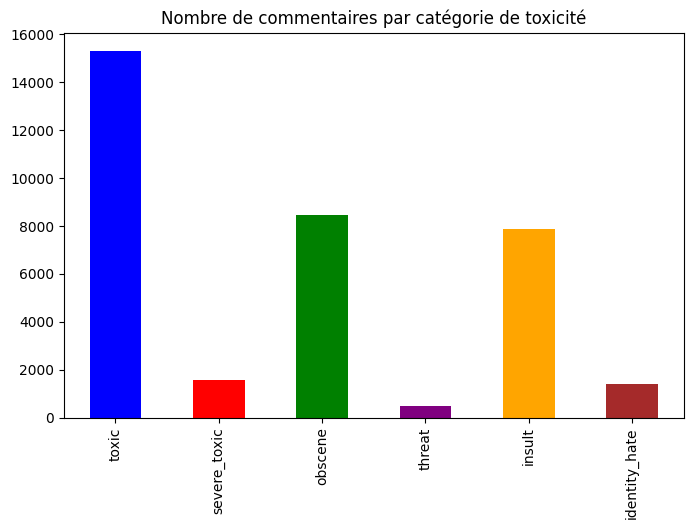

In [7]:
#reparition des classes par catégorie de toxicité

# Compter les occurrences de chaque classe
label_counts = data.iloc[:, 2:].sum()

# Affichage en barres
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color=['blue', 'red', 'green', 'purple', 'orange', 'brown'])
plt.title("Nombre de commentaires par catégorie de toxicité")
plt.show()


notre jeu de données est constitué de commentaires jugés non toxiques :


In [8]:
#voir le pourcentage de commentaires jugés non toxiques

clean_comments = (data.iloc[:, 2:].sum(axis=1) == 0).mean()
print(f"Pourcentage de commentaires non toxiques: {clean_comments:.2%}")


Pourcentage de commentaires non toxiques: 89.83%


On affiche des exemples de commentaires pour pouvoir avoir en plus une idée visuel des types d'insultes, menaces, etc...

In [9]:
#voir des exemples de commentaires (1 toxique et 1 non toxique)

# Exemple d'un commentaire toxique
print(data[data["toxic"] == 1]["comment_text"].sample(5).values)

# Exemple d'un commentaire propre
print(data[(data.iloc[:, 2:].sum(axis=1) == 0)]["comment_text"].sample(5).values)


['Hi, my name is Widr and I love to suck some African mansausage.'
 "Nice to see you bury shit you don't like, ScrapIronIV. Typical Wikipedian. Kindly go fuck yourself, asshole."
 "Persoinal Attack? \n\nIf you think I made a personalk attack, then you have some serious issues.\nMaybe your just the gay guy that everyone picked on so you don't have thick skin.\n\nYou can block me, iot happens almost daily, I MIGHT run out of ips soon, I only have about 400 left though.\n\nI run an ISP mate, I own 14 net ranges, thats 250 ip addresses X 14.\n\nWhy dont you just get your hand off your dick and actually look at the problem instead of being a pussy about it because I KNOW you dont want to have to fix your broken page every 5 seconds with an open proxy robot defacing it."
 'I guess that is all about your age. You are too old and cannot update the data you already have in your brain. How can one explain so huge desire to offend people? 94.244.129.207'
 'this guys a fuckin prick and if i ever c

In [10]:
#vérifier qu'aucune donnée n'est manquante

print(data.isnull().sum())


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


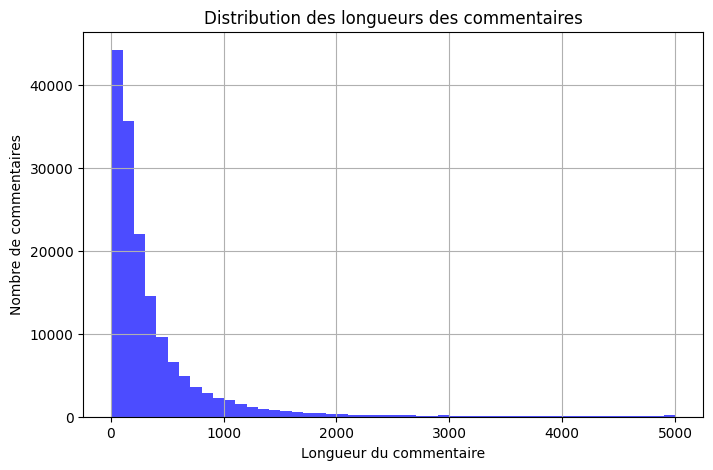

In [11]:
#analyse des longueurs de commentaires

data["comment_length"] = data["comment_text"].apply(len)

plt.figure(figsize=(8,5))
data["comment_length"].hist(bins=50, color='blue', alpha=0.7)
plt.title("Distribution des longueurs des commentaires")
plt.xlabel("Longueur du commentaire")
plt.ylabel("Nombre de commentaires")
plt.show()


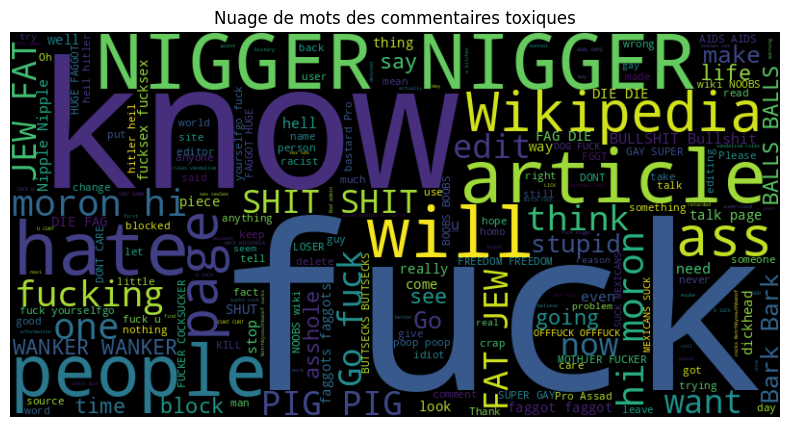

In [12]:
#faire un nuage de mot pour voir les mots toxiques récurrents

from wordcloud import WordCloud

toxic_comments = " ".join(data[data["toxic"] == 1]["comment_text"])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(toxic_comments)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des commentaires toxiques")
plt.show()


# Préparation des données

Nous avons pu analyser les données et donc voir ce que nous avons dans notre jeu de données.

Nous avons maintenant une colonne contenant des commentaires sous forme de texte brut, et pour pouvoir les utiliser efficacement dans nos analyses, nous devons les nettoyer.

---

**Pourquoi nettoyer le texte ?**

Le nettoyage du texte permet de simplifier les données en éliminant des éléments qui ne sont pas pertinents pour l'analyse. Par exemple, des éléments comme les liens URL, les mentions de profils sur les réseaux sociaux (comme @username), les hashtags (#motcle), ou encore les ponctuations, ne nous aident généralement pas à comprendre le sens du texte. L'objectif est de nous concentrer sur les mots porteurs de sens.

---

**Comment procédons-nous pour nettoyer le texte ?**

On met en minuscules, nous commençons par transformer tout le texte en minuscules. Cela garantit que nous traitons "Bonjour" et "bonjour" de la même manière.

On s'occupe aussi de supprimer les liens, les mentions et les hashtags, ils n'ont pas d'utilités pour ce projet et nous cherchons à nous concentrer sur les commentaires toxiques.

On supprime la ponctuation et les chiffres.

---

**Tokenisation :**

Ensuite, nous divisons le texte en mots, un processus appelé "tokenisation". Cela nous permet de traiter chaque mot individuellement, facilitant ainsi les analyses ultérieures.

Suppression des "stopwords" plus précisement certains mots très fréquents, comme "et", "le", "la", "is", "in", etc., sont retirés car ils n'apportent pas de valeur significative à l'analyse.

In [13]:
#nettoyage du texte

import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Download the punkt_tab data
nltk.download('stopwords')  # Add this line to download stopwords



STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    # Mettre en minuscules
    text = text.lower()
    # Supprimer les liens
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Supprimer les mentions et hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Supprimer les stopwords
    words = [word for word in words if word not in STOPWORDS]
    return " ".join(words)

# Appliquer le nettoyage
data["clean_text"] = data["comment_text"].apply(clean_text)

# Vérifier le résultat
print(data[["comment_text", "clean_text"]].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                          clean_text  
0  explanation edits made username hardcore metal...  
1  daww matches background colour im seemingly st...  
2  hey man im really trying edit war guy constant...  
3  cant make real suggestions improvement wondere...  
4                sir hero chance remember page thats  


**Stemming :**

Cela consiste à réduire un mot à sa racine, en coupant les suffixes. Par exemple, "running" devient "run". Cette méthode est souvent plus rapide mais peut parfois donner des résultats moins précis.


\
**Lemmatisation :**

La lemmatisation est un processus plus sophistiqué qui transforme un mot en son "lemme" (forme canonique) en prenant en compte son sens et sa position grammaticale. Par exemple, "better" sera transformé en "good", et "running" sera réduit à "run" en tant que verbe.

In [14]:
#stemming

from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("wordnet")

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatisation
    return " ".join(words)

# Appliquer la transformation
data["processed_text"] = data["clean_text"].apply(preprocess_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...


On représenter les mots sous forme de vecteurs numériques, ce qui permet de capturer leurs relations sémantiques. Word2Vec est un modèle d'apprentissage qui génère ces représentations vectorielles.

In [15]:
#word embeddings pour representer le texte
!pip install gensim

from gensim.models import Word2Vec

tokenized_sentences = [word_tokenize(text) for text in data["processed_text"]]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Exemple de représentation pour "toxic"
print(word2vec_model.wv["toxic"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
[-0.16886145  0.00412961  0.15723653 -0.08611763 -0.6610268  -0.12791745
 -0.02095152  0.6111289  -0.05329122  0.13820314 -0.149411   -0.3489581
 -0.02635449  0.2516956  -0.18370458 -0.38296548 -0.08307877 -0.06995981
 -0.07144085 -0.39990753  0.41233197  0.1258592  -0.1766188  -0.45925567
 -0.1759502   0.11593722 -0.20211689 -0.27222604 -0.59377533  0.14731044
  0.16355062  0.15482065  0.08094114 -0.24527103  0.11405059  0.02575906
  0.01935494 -0.17738198  0.05081084 -0.3306554   0.10369371 -0.52102244
 -0.0737334  -0.16416582  0.31028575  0.00721418 -0.06718703 -0.16783336
  0.07768513 -0.02866446 -0.

Comme les commentaires "toxiques" sont beaucoup plus fréquentes que d'autres. Cela peut biaiser les modèles d'apprentissage automatique. Pour corriger cela, nous utilisons les poids de classe.

In [16]:
#gestion des desequilibre des classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Get unique classes from the target variable
unique_classes = np.unique(data[labels].values) # Get unique classes from all target columns

# Calculer les poids des classes
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=data[labels].values.ravel())
print(class_weights)

[ 0.51902685 13.63932418]


# Entraînement du modèle baseline

Nous allons utiliser 2 techniques, la première sera du random forest et pour la deuxième nous utiliserons BERT de Google

####Random Forest


In [17]:
# Random Forest

# Random Forest avec Pipeline


# Charger les données (assumons que 'data' est déjà défini)
# Prendre un échantillon aléatoire de 10% des données
sample_df = data.sample(frac=0.5, random_state=42)

# Features et labels
X = sample_df["processed_text"]
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création de la pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Étape 1 : Vectorisation TF-IDF
    ('rf', MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42)))  # Étape 2 : Modèle Random Forest multi-label
])

# Entraînement de la pipeline
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]))

# Sauvegarde de la pipeline
import joblib
joblib.dump(pipeline, "rf_toxicity_pipeline.pkl")
print("Pipeline sauvegardée !")


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prédictions
y_pred = pipeline.predict(X_test)

# Étiquettes de sortie
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Initialisation de la figure
plt.figure(figsize=(15, 12))

# Itérer sur chaque label pour générer la matrice de confusion
for i, label in enumerate(labels):
    plt.subplot(2, 3, i+1)

    # Calcul de la matrice de confusion pour chaque étiquette
    cm = confusion_matrix(y_test[label], y_pred[:, i])

    # Visualisation avec seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])

    # Ajouter le titre et les labels
    plt.title(f'Matrice de Confusion - {label}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')

plt.tight_layout()
plt.show()


In [ ]:
def predict_toxicity(text):
    # Charger la pipeline
    pipeline = joblib.load("rf_toxicity_pipeline.pkl")

    # Prédire directement sur le texte brut
    prediction = pipeline.predict([text])[0]  # [text] car predict attend une liste

    # Convertir en dictionnaire
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    results = {label: int(pred) for label, pred in zip(labels, prediction)}

    return results

# Test interactif
while True:
    user_text = input("Entrez un message (ou 'exit' pour quitter) : ")
    if user_text.lower() == "exit":
        break
    prediction = predict_toxicity(user_text)
    print("\nPrédiction :", prediction)

####BERT

In [ ]:
!pip install datasets

In [ ]:
# BERT de Google

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Prendre 10% des données
sample_df = data.sample(frac=0.1, random_state=42)

# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

# Fonction de tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Séparation en train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    sample_df["comment_text"].tolist(), sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values, test_size=0.2
)

# Conversion en Dataset Hugging Face
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Charger le modèle BERT
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)


In [ ]:
# Entrainement sur 10% des données

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,  # On fait 1 epoch pour tester rapidement
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

In [ ]:
# Evaluation

predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions))  # Activation sigmoïde
preds = (preds.numpy() > 0.5).astype(int)  # Seuil 0.5 pour classifier

print(classification_report(test_labels, preds))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import torch
import numpy as np

# Prédictions sur les données de test avec BERT
predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions))  # Activation sigmoïde
preds = (preds.numpy() > 0.5).astype(int)

# Calculer la matrice de confusion pour chaque étiquette
cms = multilabel_confusion_matrix(test_labels, preds) # Use multilabel_confusion_matrix instead

# Afficher les matrices de confusion
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (label, cm) in enumerate(zip(labels, cms)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matrice de Confusion - {label}')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Vraies étiquettes')
plt.tight_layout()
plt.show()

# Calculer et afficher le rapport de classification pour chaque étiquette
report = classification_report(test_labels, preds, target_names=labels, output_dict=True) # Add target_names for better readability
for label in labels:
    print(f"Rapport de classification pour {label}:")
    print(f"  Précision: {report[label]['precision']:.2f}")
    print(f"  Rappel: {report[label]['recall']:.2f}")
    print(f"  F1-score: {report[label]['f1-score']:.2f}")
    print(f"  Support: {report[label]['support']}")
    print("-" * 30)

# Itération de la modélisation

# Version secondaire de BERT (DistilBERT)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import numpy as np

# Charger les données
sample_df = data.sample(frac=0.5, random_state=42)
X = sample_df["processed_text"].values
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

# Paramètres
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Taille max des séquences
EMBEDDING_DIM = 100  # Taille des embeddings

# Tokenization et transformation en séquences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Construction du modèle LSTM
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(128, return_sequences=True)),  # LSTM bidirectionnel
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation='sigmoid')  # 6 sorties pour la classification multi-label
])

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Sauvegarde du modèle et du tokenizer
model.save("lstm_toxicity_model")
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Modèle et tokenizer sauvegardés !")

# Fonction de prédiction
def predict_toxicity(text):
    model = tf.keras.models.load_model("lstm_toxicity_model")

    # Charger le tokenizer
    with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)

    # Tokenization et padding
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

    # Prédiction
    prediction = model.predict(padded_sequence)[0]
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    results = {label: float(pred) for label, pred in zip(labels, prediction)}

    return results

# Test interactif
while True:
    user_text = input("Entrez un message (ou 'exit' pour quitter) : ")
    if user_text.lower() == "exit":
        break
    prediction = predict_toxicity(user_text)
    print("\nPrédiction :", prediction)
